In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time

from dask.distributed import Client
from dask import delayed
from dask import compute

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import data_utils.data_analysis as data_analysis
import data_utils.pulse as pulse
import models.tools as models_tools
import models.rf as rf
import models.fcnn as fcnn

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
#Average shots with same input param
def shot_average(df_input,df_time):
    goodness_list=[]
    o2_list=[]
    o3_list=[]
    o4_list=[]
    #wizz_list=[]
    #goodness_mean=[]
    wizz_mean=[]
    #emax_std=[]
    counter=0
    for index,row in df_input.iterrows():
        o2=row['order2']
        o3=row['order3']
        o4=row['order4']
        #print(index)
        if(index==0):
            #goodness_list.append(row['goodness'])
            wizz_list=df_time.iloc[index].to_numpy()
            #print(wizz_list)
            counter=1
        if(index>0):
            o2_prev=df_input['order2'].iloc[index-1]
            o3_prev=df_input['order3'].iloc[index-1]
            o4_prev=df_input['order4'].iloc[index-1]
            if(o2==o2_prev and o3==o3_prev and o4==o4_prev):
                counter+=1
                #goodness_list.append(row['goodness'])
                wizz_list=np.vstack([wizz_list,df_time.iloc[index].to_numpy()])
                #print(wizz_list)
                #ecut_list.append(df_metrics['Cutoff E'].iloc[index])
                #integ_list.append(df_metrics['Integr norm'].iloc[index])
            else:
                #do the avg (from the previous shots)
                #goodness_mean.append(np.mean(goodness_list))
                wizz_mean.append(np.mean(wizz_list,axis=0))
                ##print(wizz_mean)
                ##print(counter)
                #emax_std.append(np.std(emax_list))
                #ecut_mean.append(np.mean(ecut_list))
                #ecut_std.append(np.std(ecut_list))
                o2_list.append(o2_prev)
                o3_list.append(o3_prev)
                o4_list.append(o4_prev)
                
                #AND start the new batch
                #goodness_list=[row['goodness']]
                wizz_list=df_time.iloc[index].to_numpy()
                #ecut_list=[df_metrics['Cutoff E'].iloc[index]]
                #integ_list=[df_metrics['Integr norm'].iloc[index]]
                #print(counter)
                counter=1
            #print(counter)

    df_input_avg=pd.DataFrame()
    df_time_avg=pd.DataFrame(wizz_mean)
    df_input_avg['order2']=o2_list
    df_input_avg['order3']=o3_list
    df_input_avg['order4']=o4_list
    #df_input_avg['goodness mean']=goodness_mean
    #df_metrics_avg['Emax std']=emax_std
    return df_input_avg,df_time_avg

In [3]:
client = Client(n_workers=20)

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44569 instead
  warnings.warn(


In [4]:
client.cluster

LocalCluster(b586acb1, 'tcp://127.0.0.1:39825', workers=20, threads=20, memory=31.02 GiB)

In [5]:
#client.close()

In [6]:
filename='datasets/galadriel_dataset_24_09_18_high_res.h5'
df_input,df_time_val,df_time,df_freq_val,df_freq_int = data_analysis.read_dataset(filename)

Input DF
      shot number   order2   order3     order4  goodness
0          163165  34400.0 -23000.0 -5500000.0  0.945039
1          163166  34400.0 -23000.0 -5500000.0  0.862834
2          163167  34400.0 -23000.0 -5500000.0  0.834347
3          163168  34400.0 -23000.0 -5500000.0  0.873099
4          163169  34400.0 -23000.0 -5500000.0  0.851336
...           ...      ...      ...        ...       ...
9498       172664  35400.0  28000.0 -4000000.0  1.031447
9499       172665  35400.0  28000.0 -4000000.0  1.031718
9500       172666  35400.0  28000.0 -4000000.0  1.009015
9501       172667  35400.0  28000.0 -4000000.0  1.199801
9502       172668  35400.0  28000.0 -4000000.0  1.241150

[9503 rows x 5 columns]
----
Time values
0    -104.962227
1     -94.466005
2     -83.969782
3     -73.473559
4     -62.977336
5     -52.481114
6     -41.984891
7     -31.488668
8     -20.992445
9     -10.496223
10      0.000000
11     10.496223
12     20.992445
13     31.488668
14     41.984891
15     52.

In [7]:
df_spec_freq=pd.read_hdf(filename,'df_spec_freq')
df_spec_int=pd.read_hdf(filename,'df_spec_int')
df_spec_phase=pd.read_hdf(filename,'df_spec_phase')

In [8]:
#time in fs (it is the boundariy)
def pulse_reconst_old(df_spec_int,df_spec_freq,df_spec_phase,time=100,time_bins=100):
    t = np.linspace(-time,time,time_bins+1)#*1e-15   ## time array, in fs.
    c = 299792458 ## speed of light in m/s
    center_freq = c/800e-9  ## define the center frequency using the known center wavelength of GALADRIEL, 800nm
    
    p_list=[]
    for i in range(0,len(df_spec_freq)):
        intensity=df_spec_int.loc[i].to_numpy()
        frequency=df_spec_freq.loc[i].to_numpy()
        phase=df_spec_phase.loc[i].to_numpy()
        p = pulse.pulse(t,frequency*1e12,intensity,phase,wavelength=False,center=center_freq)
        p_list.append(p.intensity)
    
    return t,pd.DataFrame(p_list)

In [9]:
#time in fs (it is the boundariy)
def pulse_reconst_dask(df_spec_int,df_spec_freq,df_spec_phase,time=100,time_bins=100):
    t = np.linspace(-time,time,time_bins+1)#*1e-15   ## time array, in fs.
    c = 299792458 ## speed of light in m/s
    center_freq = c/800e-9  ## define the center frequency using the known center wavelength of GALADRIEL, 800nm
    
    p_list=[]
    for i in range(0,len(df_spec_freq)):
        intensity=df_spec_int.loc[i].to_numpy()
        frequency=df_spec_freq.loc[i].to_numpy()
        phase=df_spec_phase.loc[i].to_numpy()
        p = delayed(pulse.pulse)(t,frequency*1e12,intensity,phase,wavelength=False,center=center_freq)
        #p_list.append(p.intensity)
        p_list.append(p)
    p_list=compute(p_list)[0]
    p_int=[p.intensity for p in p_list]
    return t,pd.DataFrame(p_int)
    #return t,p_int

In [10]:
#time in fs (it is the boundariy)
def pulse_reconst(df_spec_int,df_spec_freq,df_spec_phase,time=100,time_bins=100):
    t = np.linspace(-time,time,time_bins+1)#*1e-15   ## time array, in fs.
    c = 299792458 ## speed of light in m/s
    center_freq = c/800e-9  ## define the center frequency using the known center wavelength of GALADRIEL, 800nm
    
    #p_list=[]
    p_list= [pulse.pulse(t,freq*1e12,inten,phase,wavelength=False,center=center_freq).intensity
             for inten,freq,phase in zip(df_spec_int.to_numpy(), df_spec_freq.to_numpy(),df_spec_phase.to_numpy())]

    #for i in range(0,len(df_spec_freq)):
    #    intensity=df_spec_int.loc[i].to_numpy()
    #    frequency=df_spec_freq.loc[i].to_numpy()
    #    phase=df_spec_phase.loc[i].to_numpy()
    #    p = pulse.pulse(t,frequency*1e12,intensity,phase,wavelength=False,center=center_freq)
    #    p_list.append(p.intensity)
    
    return t,pd.DataFrame(p_list)

In [11]:
%%time
#t_200,df_pulse_200=pulse_reconst(df_spec_int,df_spec_freq,df_spec_phase,time=150,time_bins=200)
t_200,df_pulse_200=pulse_reconst_dask(df_spec_int,df_spec_freq,df_spec_phase,time=150,time_bins=200)

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 224.75 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 17.9 s, sys: 2.21 s, total: 20.1 s
Wall time: 24.1 s


In [12]:
#AVG pulses
df_input_avg,df_pulse_200_avg=shot_average(df_input,df_pulse_200)

## TRain roundtrip model

In [13]:
#split the dataset (X:dazzler param, Y:wizzler)
#all shots 
#X_train, X_test, y_train, y_test=models_tools.split_dataset_roundtrip(df_input,df_pulse_200,rand_split=False)
#Avg shots
X_train, X_test, y_train, y_test=models_tools.split_dataset_roundtrip(df_input_avg,df_pulse_200_avg,rand_split=False)

In [14]:
%%time
roundmodel_rf=rf.ROUNDmodelRF(X_train,X_test,y_train,y_test)
roundmodel_rf.train()
y_predict_round=roundmodel_rf.predict(y_test)
mae_error_round=roundmodel_rf.error_calc()

Calculating the Mean Absolute Error
CPU times: user 30.4 s, sys: 675 ms, total: 31.1 s
Wall time: 27.5 s


/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [15]:
#x (dazzler prediction)
X_predict_round=roundmodel_rf.X_predict

Text(0.5, 1.0, 'Roundtrip Model Accuracy')

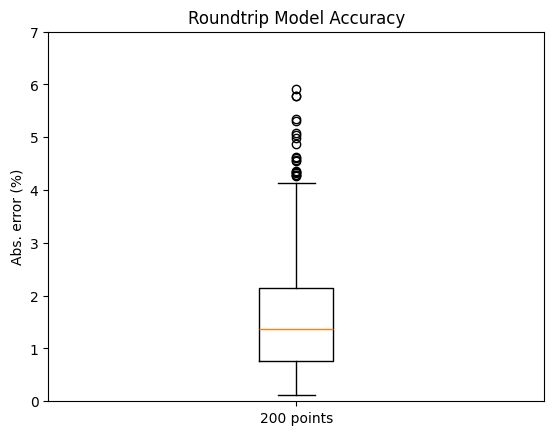

In [16]:
error_dist=[100*mae_error_round]
labels=['200 points']
plt.boxplot(error_dist,labels=labels)
#plt.boxplot(df_error_forward_7k_whole)
#plt.boxplot(df_error_forward_4k_whole)
plt.ylim(0,7)
plt.ylabel('Abs. error (%)')
plt.title('Roundtrip Model Accuracy')

In [17]:
def plot_example(y_test,df_time,y_predict_fwd,X_predict_bwd):

    order2= X_predict_bwd[0]
    order3=X_predict_bwd[1]
    order4=X_predict_bwd[2]
    
    plt.plot(df_time,y_test,label='Test shot',linewidth=3)
    #plt.plot(df_time_val,y_predict_lin_backforw[shot_index],label='Prediction (Linear)')
    plt.plot(df_time,y_predict_fwd,label='Prediction (RF)',linewidth=3,linestyle='--')

    mae='{:6.2f}'.format(100*mean_absolute_error(y_test,y_predict_fwd))
    plt.title('Mean abs. error:'+mae+'%',fontsize=14)
    plt.text(35, 0.7, r'$\beta^2=$'+str(order2), dict(size=14))
    plt.text(35, 0.6, r'$\beta^3=$'+str(order3), dict(size=14))
    plt.text(35, 0.5, r'$\beta^4=$'+str(order4), dict(size=14))
    plt.xlabel('Time(fs)',fontsize=14)
    plt.ylabel('Intensity',fontsize=14)
    plt.legend(loc='upper left')

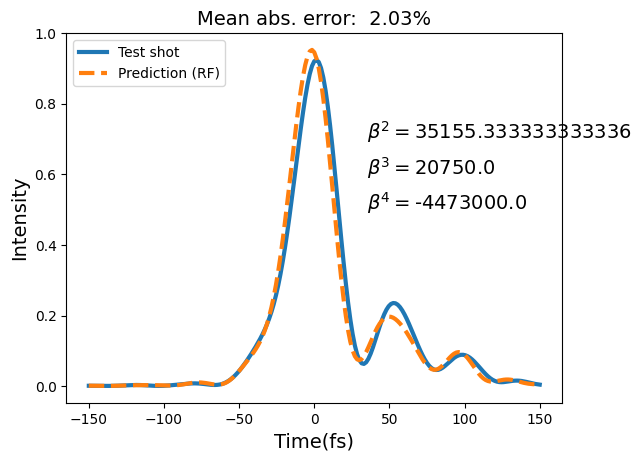

In [18]:
shot_index=140
plot_example(y_test.iloc[shot_index],t_200,y_predict_round[shot_index], X_predict_round[shot_index])

## Custom pulse

In [19]:
#define the curve to fit
def func(t,a0, a1,a2,
        b0,b1,b2,
        c0,c1,c2,
        d0,d1,d2,
        e0,e1,e2): 
    #envelope=1*np.exp(-((t-0)**2)/(2*30*30))
    return (a0*np.exp(-((t-a1)**2)/(2*a2*a2))
            +b0*np.exp(-((t-b1)**2)/(2*b2*b2))
           +c0*np.exp(-((t-c1)**2)/(2*c2*c2))
           +d0*np.exp(-((t-d1)**2)/(2*d2*d2))
           +e0*np.exp(-((t-e1)**2)/(2*e2*e2)))

/tmp/ipykernel_37735/130125069.py:12: RuntimeWarning: divide by zero encountered in divide
  +e0*np.exp(-((t-e1)**2)/(2*e2*e2)))
/tmp/ipykernel_37735/130125069.py:12: RuntimeWarning: invalid value encountered in divide
  +e0*np.exp(-((t-e1)**2)/(2*e2*e2)))


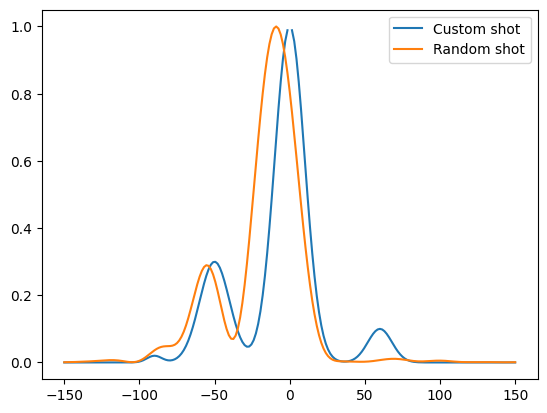

In [20]:
f=func(t_200,1,0,10,
       0.02,-90,5,
      0.3,-50,10,
      0.1,60,8,
      0,0,0)
plt.plot(t_200,f,label='Custom shot')
plt.plot(t_200,df_pulse_200.iloc[3550],label='Random shot')
plt.legend()

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


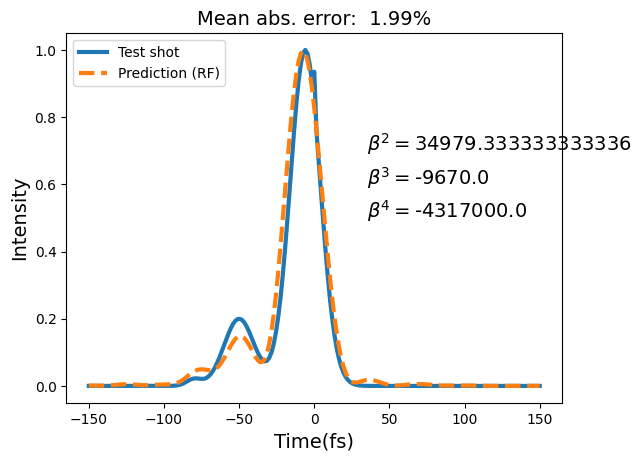

In [21]:
y_cust_shot=func(t_200,1,-6,10,
       0.02,-80,5,
      0.2,-50,10,
      0.,60,8,
    0.1,0,0.1)
y_predict_cust=roundmodel_rf.predict([y_cust_shot])
X_predict_cust=roundmodel_rf.X_predict
X_predict_cust
plot_example(y_cust_shot,t_200,y_predict_cust[0], X_predict_cust[0])

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


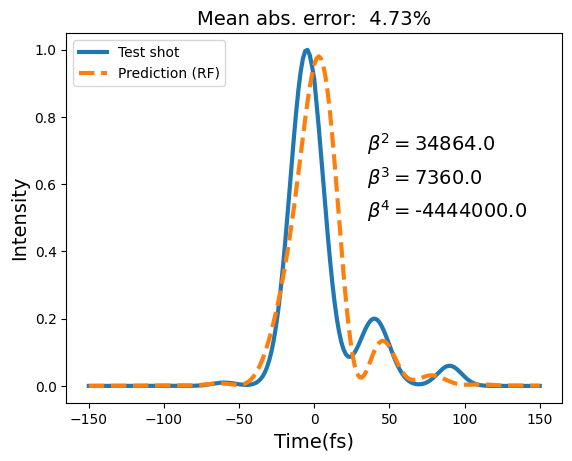

In [22]:
y_cust_shot=func(t_200,1,-5,11,
       0.06,+90,8,
      0.2,+40,10,
      0.01,-60,8,
    0.01,0,0.1)
y_predict_cust=roundmodel_rf.predict([y_cust_shot])
X_predict_cust=roundmodel_rf.X_predict
X_predict_cust
plot_example(y_cust_shot,t_200,y_predict_cust[0], X_predict_cust[0])

# Train the NN and use them also to generate pulse

In [23]:
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device="cpu"
print("We are using:",device)

We are using: cpu


In [24]:
fwdmodelNN=fcnn.FWmodelNN(X_train,y_train,X_test,y_test,device)
fwdmodelNN.train(300,#epochs
                 20,#batch size
                 20, #print freq
                 0.001) #learning rate

Finished epoch 0,latest loss 0.020358899608254433
Finished epoch 20,latest loss 0.000606889312621206
Finished epoch 40,latest loss 0.0004059447383042425
Finished epoch 60,latest loss 0.00030818398226983845
Finished epoch 80,latest loss 0.0002487762540113181
Finished epoch 100,latest loss 0.0002659535384736955
Finished epoch 120,latest loss 0.00023827713448554277
Finished epoch 140,latest loss 0.00018752957112155855
Finished epoch 160,latest loss 0.00020617958216462284
Finished epoch 180,latest loss 0.00012127793888794258
Finished epoch 200,latest loss 0.0001078431960195303
Finished epoch 220,latest loss 9.136009612120688e-05
Finished epoch 240,latest loss 9.962272451957688e-05
Finished epoch 260,latest loss 7.476460450561717e-05
Finished epoch 280,latest loss 0.0001916356268338859
Finished epoch 299,latest loss 8.209647057810798e-05
Total time taken to train the model: 119.06s


In [25]:
y_predict_nn=fwdmodelNN.predict(X_test)
error_fwd_model_nn=fwdmodelNN.error_calc_mae()

Calculating the Mean Absolute Error


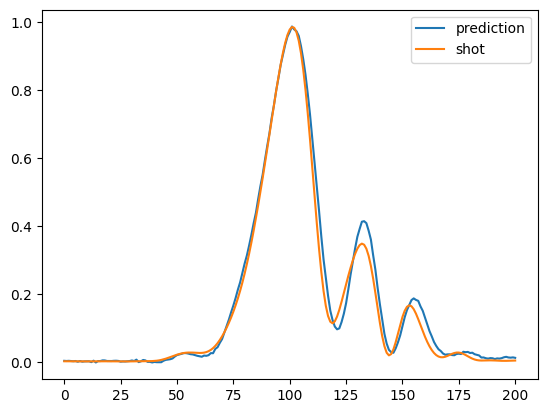

In [26]:
shot_ind=105
plt.plot(y_predict_nn[shot_ind],label='prediction')
plt.plot(y_test.iloc[shot_ind],label='shot')
plt.legend()

Text(0.5, 1.0, 'FWD NN Model Accuracy')

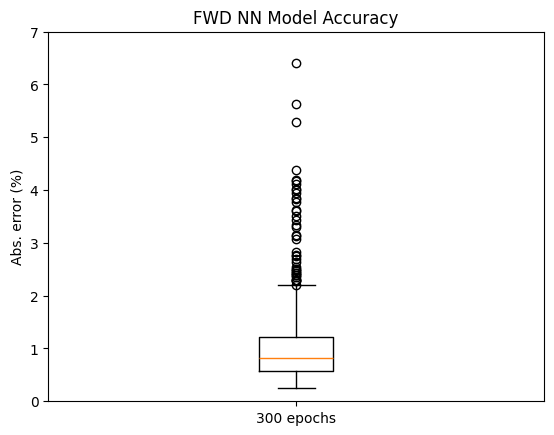

In [27]:
error_dist=[100*error_fwd_model_nn]
labels=['300 epochs']
plt.boxplot(error_dist,labels=labels)
#plt.boxplot(df_error_forward_7k_whole)
#plt.boxplot(df_error_forward_4k_whole)
plt.ylim(0,7)
plt.ylabel('Abs. error (%)')
plt.title('FWD NN Model Accuracy')

In [28]:
#round model
roundmodelNN=fcnn.ROUNDmodelNN(X_train,y_train,X_test,y_test,device)
roundmodelNN.train(300,#epochs FWD
                 20,#batch size FWD
                 20, #print freq FWD
                 0.001, #learning rate FWF
                   600,#epochs  BWD
                 20,#batch size BWD
                 50, #print freq BWD
                 0.001) #learning rate BWD

Training the forward model
Finished epoch 0,latest loss 0.020384976640343666
Finished epoch 20,latest loss 0.0005842134123668075
Finished epoch 40,latest loss 0.0004094653413631022
Finished epoch 60,latest loss 0.00029924200498498976
Finished epoch 80,latest loss 0.00031758472323417664
Finished epoch 100,latest loss 0.00020720760221593082
Finished epoch 120,latest loss 0.00018767478468362242
Finished epoch 140,latest loss 0.00019213772611692548
Finished epoch 160,latest loss 0.00016580673400312662
Finished epoch 180,latest loss 0.0001508873829152435
Finished epoch 200,latest loss 0.0001555090566398576
Finished epoch 220,latest loss 9.631187276681885e-05
Finished epoch 240,latest loss 0.00010473732982063666
Finished epoch 260,latest loss 9.394917287863791e-05
Finished epoch 280,latest loss 8.445941057289019e-05
Finished epoch 299,latest loss 0.00012439300189726055
Total time taken to train the model: 98.68s
Training the backward model
Finished epoch 0,latest loss 1.0106513500213623
Fini

In [29]:
y_predict_nn_round=roundmodelNN.predict(y_test)
error_round_model_nn=roundmodelNN.error_calc_mae()

Calculating the Mean Absolute Error


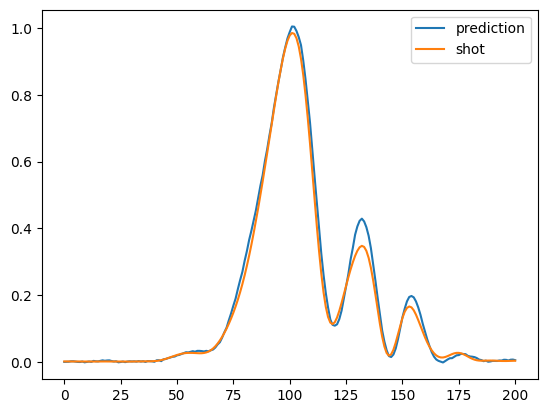

In [30]:
shot_ind=105
plt.plot(y_predict_nn_round[shot_ind],label='prediction')
plt.plot(y_test.iloc[shot_ind],label='shot')
plt.legend()

Text(0.5, 1.0, 'Roundtrip Model Accuracy')

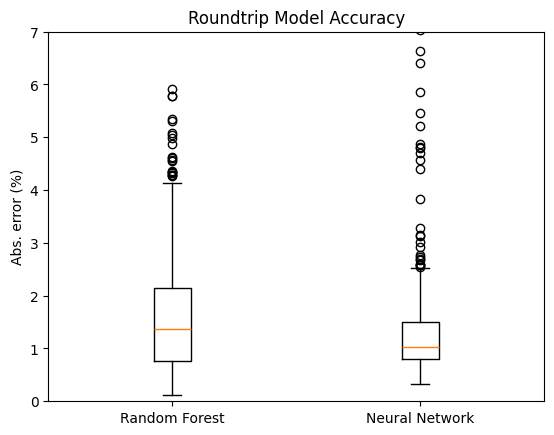

In [31]:
error_dist=[100*mae_error_round,
            100*error_round_model_nn]
labels=['Random Forest','Neural Network']
plt.boxplot(error_dist,labels=labels)
#plt.boxplot(df_error_forward_7k_whole)
#plt.boxplot(df_error_forward_4k_whole)
plt.ylim(0,7)
plt.ylabel('Abs. error (%)')
plt.title('Roundtrip Model Accuracy')

### Make the predictions again from the custom shots

In [32]:
def plot_example2(y_test,df_time,y_predict_rf,X_predict_rf,
                 y_predict_nn,X_predict_nn):

    order2_rf= X_predict_rf[0]
    order3_rf=X_predict_rf[1]
    order4_rf=X_predict_rf[2]
    order2_nn= X_predict_nn[0]
    order3_nn=X_predict_nn[1]
    order4_nn=X_predict_nn[2]
    
    plt.plot(df_time,y_test,label='Test shot',linewidth=3)
    #plt.plot(df_time_val,y_predict_lin_backforw[shot_index],label='Prediction (Linear)')
    plt.plot(df_time,y_predict_rf,label='Prediction (RF)',linewidth=3,linestyle='--')
    plt.plot(df_time,y_predict_nn,label='Prediction (NN)',linewidth=3,linestyle=':')

    #mae='{:6.2f}'.format(100*mean_absolute_error(y_test,y_predict_fwd))
    #plt.title('Mean abs. error:'+mae+'%',fontsize=14)
    plt.text(35, 0.7, r'$\beta^2_{RF}=$'+str(order2_rf), dict(size=11))
    plt.text(35, 0.6, r'$\beta^3_{RF}=$'+str(order3_rf), dict(size=11))
    plt.text(35, 0.5, r'$\beta^4_{RF}=$'+str(order4_rf), dict(size=11))
    plt.text(-130, 0.7, r'$\beta^2_{NN}=$'+str(order2_nn), dict(size=11))
    plt.text(-130, 0.6, r'$\beta^3_{NN}=$'+str(order3_nn), dict(size=11))
    plt.text(-130, 0.5, r'$\beta^4_{NN}=$'+str(order4_nn), dict(size=11))
    plt.xlabel('Time(fs)',fontsize=14)
    plt.ylabel('Intensity',fontsize=14)
    plt.legend(loc='upper left')

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


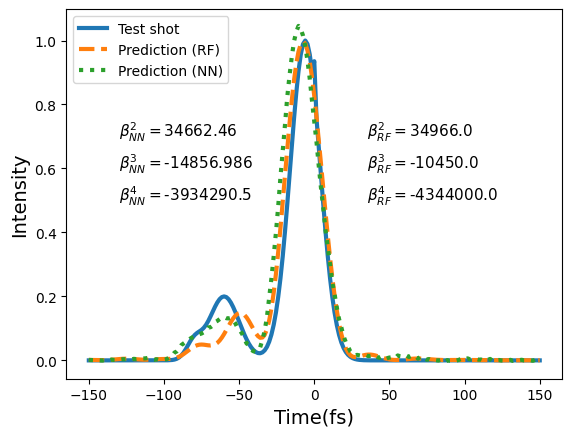

In [33]:
y_cust_shot=func(t_200,1,-6,10,
       0.05,-80,5,
      0.2,-60,10,
      0.,60,8,
    0.1,0,0.1)
y_predict_cust_rf=roundmodel_rf.predict([y_cust_shot])
X_predict_cust_rf=roundmodel_rf.X_predict
#plot_example(y_cust_shot,t_200,y_predict_cust_rf[0], X_predict_cust_rf[0])
y_predict_cust_nn=roundmodelNN.predict(pd.DataFrame([y_cust_shot]))
X_predict_cust_nn=roundmodelNN.X_predict_nn
plot_example2(y_cust_shot,t_200,y_predict_cust_rf[0], X_predict_cust_rf[0],
             y_predict_cust_nn[0], X_predict_cust_nn[0])

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


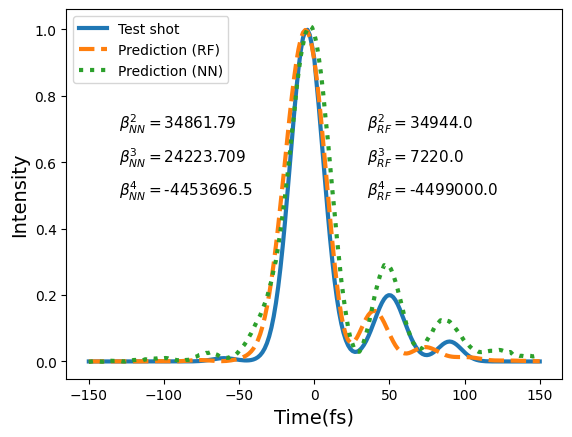

In [34]:
y_cust_shot=func(t_200,1,-5,11,
       0.06,+90,8,
      0.2,+50,10,
      0.01,-60,8,
    0.01,0,0.1)
y_predict_cust_rf=roundmodel_rf.predict([y_cust_shot])
X_predict_cust_rf=roundmodel_rf.X_predict
#plot_example(y_cust_shot,t_200,y_predict_cust_rf[0], X_predict_cust_rf[0])
y_predict_cust_nn=roundmodelNN.predict(pd.DataFrame([y_cust_shot]))
X_predict_cust_nn=roundmodelNN.X_predict_nn
plot_example2(y_cust_shot,t_200,y_predict_cust_rf[0], X_predict_cust_rf[0],
             y_predict_cust_nn[0], X_predict_cust_nn[0])

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


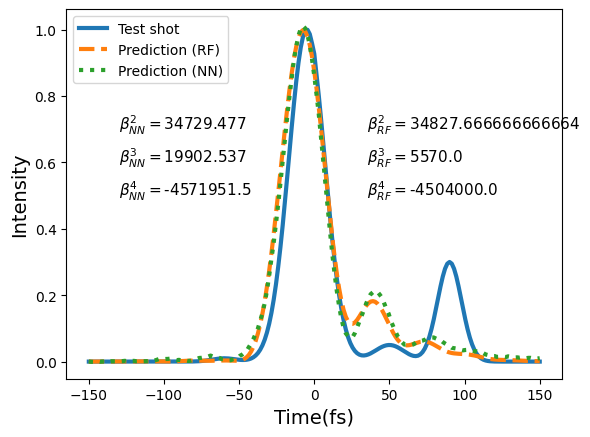

In [35]:
y_cust_shot=func(t_200,1,-5,12,
       0.3,+90,8,
      0.05,+50,10,
      0.01,-60,8,
    0.01,0,0.1)
y_predict_cust_rf=roundmodel_rf.predict([y_cust_shot])
X_predict_cust_rf=roundmodel_rf.X_predict
#plot_example(y_cust_shot,t_200,y_predict_cust_rf[0], X_predict_cust_rf[0])
y_predict_cust_nn=roundmodelNN.predict(pd.DataFrame([y_cust_shot]))
X_predict_cust_nn=roundmodelNN.X_predict_nn
plot_example2(y_cust_shot,t_200,y_predict_cust_rf[0], X_predict_cust_rf[0],
             y_predict_cust_nn[0], X_predict_cust_nn[0])

# Effects of smaller datasets

In [36]:
#np.random.seed(10)
drop_factor=0.95
def drop_shots(drop_factor,df_input,df_time):
    remove_n = int(drop_factor*len(df_input)) #number of shots to be dropped
    #print(remove_n)
    drop_indices = np.random.choice(df_input.index, remove_n, replace=False)
    df_input_subset = df_input.drop(drop_indices)
    df_time_subset = df_time.drop(drop_indices)
    #print(df_input_subset)
    #print(df_time_subset)
    print('The datasize is no: '+str(len(df_time_subset)))
    return df_input_subset,df_time_subset

In [37]:
drop_factor=0.5
df_input_subset_600,df_time_subset_600=drop_shots(drop_factor,df_input_avg,df_pulse_200_avg)
X_train_600, X_test_600, y_train_600, y_test_600=models_tools.split_dataset_roundtrip(df_input_subset_600,df_time_subset_600,rand_split=False)

The datasize is no: 594


In [38]:
drop_factor=0.75
df_input_subset_300,df_time_subset_300=drop_shots(drop_factor,df_input_avg,df_pulse_200_avg)
X_train_300, X_test_300, y_train_300, y_test_300=models_tools.split_dataset_roundtrip(df_input_subset_300,df_time_subset_300,rand_split=False)

The datasize is no: 297


In [39]:
drop_factor=0.87
df_input_subset_150,df_time_subset_150=drop_shots(drop_factor,df_input_avg,df_pulse_200_avg)
X_train_150, X_test_150, y_train_150, y_test_150=models_tools.split_dataset_roundtrip(df_input_subset_150,df_time_subset_150,rand_split=False)

The datasize is no: 155


### Train the models with the small datasets

In [40]:
#RANDOM FOREST

In [41]:
%%time
#random forest
roundmodel_rf_600=rf.ROUNDmodelRF(X_train_600,X_test_600,y_train_600,y_test_600)
roundmodel_rf_600.train()
y_predict_round_rf_600=roundmodel_rf_600.predict(y_test_600)
mae_error_round_rf_600=roundmodel_rf_600.error_calc()
#x (dazzler prediction)
X_predict_round_rf_600=roundmodel_rf_600.X_predict

roundmodel_rf_300=rf.ROUNDmodelRF(X_train_300,X_test_300,y_train_300,y_test_300)
roundmodel_rf_300.train()
y_predict_round_rf_300=roundmodel_rf_300.predict(y_test_300)
mae_error_round_rf_300=roundmodel_rf_300.error_calc()
#x (dazzler prediction)
X_predict_round_rf_300=roundmodel_rf_300.X_predict

roundmodel_rf_150=rf.ROUNDmodelRF(X_train_150,X_test_150,y_train_150,y_test_150)
roundmodel_rf_150.train()
y_predict_round_rf_150=roundmodel_rf_150.predict(y_test_150)
mae_error_round_rf_150=roundmodel_rf_150.error_calc()
#x (dazzler prediction)
X_predict_round_rf_150=roundmodel_rf_150.X_predict

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Calculating the Mean Absolute Error


/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Calculating the Mean Absolute Error
Calculating the Mean Absolute Error
CPU times: user 20.3 s, sys: 449 ms, total: 20.8 s
Wall time: 18.5 s


/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [42]:
roundmodelNN_600=fcnn.ROUNDmodelNN(X_train_600,y_train_600,X_test_600,y_test_600,device)
roundmodelNN_600.train(300,#epochs FWD
                 20,#batch size FWD
                 20, #print freq FWD
                 0.001, #learning rate FWF
                   600,#epochs  BWD
                 20,#batch size BWD
                 50, #print freq BWD
                 0.001) #learning rate BWD
y_predict_nn_round_600=roundmodelNN_600.predict(y_test_600)
error_round_model_nn_600=roundmodelNN_600.error_calc_mae()

Training the forward model
Finished epoch 0,latest loss 0.03521100804209709
Finished epoch 20,latest loss 0.0008835779735818505
Finished epoch 40,latest loss 0.0006431366200558841
Finished epoch 60,latest loss 0.00047888242988847196
Finished epoch 80,latest loss 0.0004577625368256122
Finished epoch 100,latest loss 0.0003173750592395663
Finished epoch 120,latest loss 0.00019694578077178448
Finished epoch 140,latest loss 0.00015173236897680908
Finished epoch 160,latest loss 0.0001424027723260224
Finished epoch 180,latest loss 0.00023214377870317549
Finished epoch 200,latest loss 0.00016460526967421174
Finished epoch 220,latest loss 0.00015055047697387636
Finished epoch 240,latest loss 8.70703806867823e-05
Finished epoch 260,latest loss 0.0002078208199236542
Finished epoch 280,latest loss 9.844723535934463e-05
Finished epoch 299,latest loss 0.00012063706526532769
Total time taken to train the model: 60.25s
Training the backward model
Finished epoch 0,latest loss 1.0295387506484985
Finishe

In [43]:
roundmodelNN_300=fcnn.ROUNDmodelNN(X_train_300,y_train_300,X_test_300,y_test_300,device)
roundmodelNN_300.train(300,#epochs FWD
                 20,#batch size FWD
                 20, #print freq FWD
                 0.001, #learning rate FWF
                   600,#epochs  BWD
                 20,#batch size BWD
                 50, #print freq BWD
                 0.001) #learning rate BWD
y_predict_nn_round_300=roundmodelNN_300.predict(y_test_300)
error_round_model_nn_300=roundmodelNN_300.error_calc_mae()

Training the forward model
Finished epoch 0,latest loss 0.057914670556783676
Finished epoch 20,latest loss 0.0018335976637899876
Finished epoch 40,latest loss 0.0008612108649685979
Finished epoch 60,latest loss 0.0005840504309162498
Finished epoch 80,latest loss 0.0004366384237073362
Finished epoch 100,latest loss 0.00039061560528352857
Finished epoch 120,latest loss 0.00024350952298846096
Finished epoch 140,latest loss 0.00019082931976299733
Finished epoch 160,latest loss 0.0004590753233060241
Finished epoch 180,latest loss 0.00014309986727312207
Finished epoch 200,latest loss 0.00021073334210086614
Finished epoch 220,latest loss 0.00015826952585484833
Finished epoch 240,latest loss 0.0002044537104666233
Finished epoch 260,latest loss 0.0012839435366913676
Finished epoch 280,latest loss 9.988572855945677e-05
Finished epoch 299,latest loss 6.969259993638843e-05
Total time taken to train the model: 26.72s
Training the backward model
Finished epoch 0,latest loss 1.087921380996704
Finishe

In [44]:
roundmodelNN_150=fcnn.ROUNDmodelNN(X_train_150,y_train_150,X_test_150,y_test_150,device)
roundmodelNN_150.train(300,#epochs FWD
                 20,#batch size FWD
                 20, #print freq FWD
                 0.001, #learning rate FWF
                   600,#epochs  BWD
                 20,#batch size BWD
                 50, #print freq BWD
                 0.001) #learning rate BWD
y_predict_nn_round_150=roundmodelNN_150.predict(y_test_150)
error_round_model_nn_150=roundmodelNN_150.error_calc_mae()

Training the forward model
Finished epoch 0,latest loss 0.07739671319723129
Finished epoch 20,latest loss 0.003969600424170494
Finished epoch 40,latest loss 0.001970652723684907
Finished epoch 60,latest loss 0.0010126534616574645
Finished epoch 80,latest loss 0.00065361347515136
Finished epoch 100,latest loss 0.0006041328888386488
Finished epoch 120,latest loss 0.00041578515083529055
Finished epoch 140,latest loss 0.0003181403735652566
Finished epoch 160,latest loss 0.00031330957426689565
Finished epoch 180,latest loss 0.00026337263989262283
Finished epoch 200,latest loss 0.0002113747614203021
Finished epoch 220,latest loss 0.00024252721050288528
Finished epoch 240,latest loss 0.00016507069813087583
Finished epoch 260,latest loss 0.00020765520457644016
Finished epoch 280,latest loss 0.00016650240286253393
Finished epoch 299,latest loss 0.0001122246467275545
Total time taken to train the model: 13.55s
Training the backward model
Finished epoch 0,latest loss 1.1203737258911133
Finished e

Text(0.5, 1.0, 'Roundtrip RF Model Accuracy')

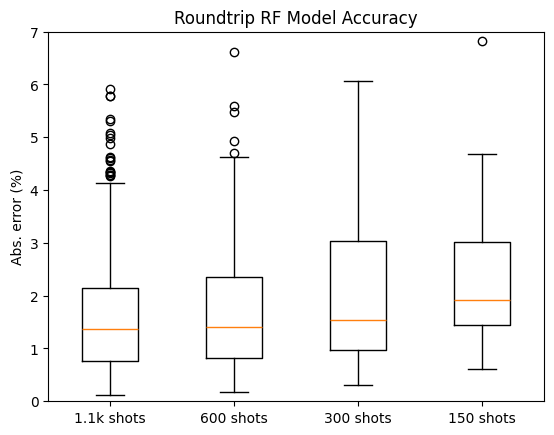

In [45]:
error_dist=[100*mae_error_round,
           100*mae_error_round_rf_600,
           100*mae_error_round_rf_300,
           100*mae_error_round_rf_150]
labels=['1.1k shots','600 shots','300 shots','150 shots']
plt.boxplot(error_dist,labels=labels)
#plt.boxplot(df_error_forward_7k_whole)
#plt.boxplot(df_error_forward_4k_whole)
plt.ylim(0,7)
plt.ylabel('Abs. error (%)')
plt.title('Roundtrip RF Model Accuracy')

Text(0.5, 1.0, 'Roundtrip NN Model Accuracy')

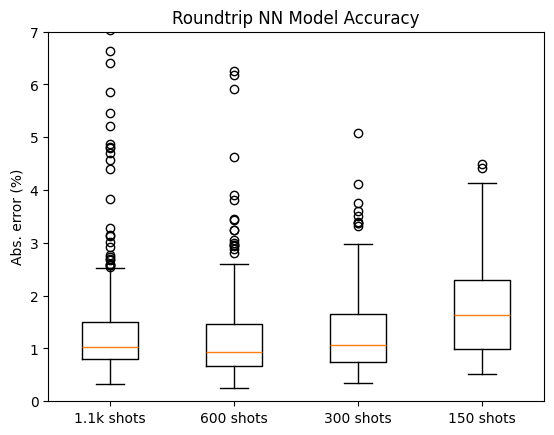

In [46]:
error_dist=[100*error_round_model_nn,
           100*error_round_model_nn_600,
           100*error_round_model_nn_300,
           100*error_round_model_nn_150]
labels=['1.1k shots','600 shots','300 shots','150 shots']
plt.boxplot(error_dist,labels=labels)
#plt.boxplot(df_error_forward_7k_whole)
#plt.boxplot(df_error_forward_4k_whole)
plt.ylim(0,7)
plt.ylabel('Abs. error (%)')
plt.title('Roundtrip NN Model Accuracy')

### Custom shots vs datasize

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


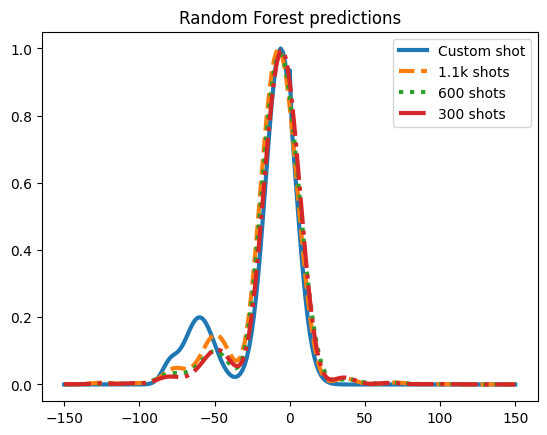

In [47]:
y_cust_shot=func(t_200,1,-6,10,
       0.05,-80,5,
      0.2,-60,10,
      0.,60,8,
    0.1,0,0.1)

y_predict_cust_rf=roundmodel_rf.predict([y_cust_shot])
X_predict_cust_rf=roundmodel_rf.X_predict
#plot_example(y_cust_shot,t_200,y_predict_cust_rf[0], X_predict_cust_rf[0])
y_predict_cust_rf_600=roundmodel_rf_600.predict([y_cust_shot])
X_predict_cust_rf_600=roundmodel_rf_600.X_predict
y_predict_cust_rf_300=roundmodel_rf_300.predict([y_cust_shot])
X_predict_cust_rf_300=roundmodel_rf_300.X_predict

plt.plot(t_200,y_cust_shot,label='Custom shot',linewidth=3)
#plt.plot(df_time_val,y_predict_lin_backforw[shot_index],label='Prediction (Linear)')
plt.plot(t_200,y_predict_cust_rf[0],label='1.1k shots',linewidth=3,linestyle='--')
plt.plot(t_200,y_predict_cust_rf_600[0],label='600 shots',linewidth=3,linestyle=':')
plt.plot(t_200,y_predict_cust_rf_300[0],label='300 shots',linewidth=3,linestyle='-.')
plt.title('Random Forest predictions')
plt.legend()

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


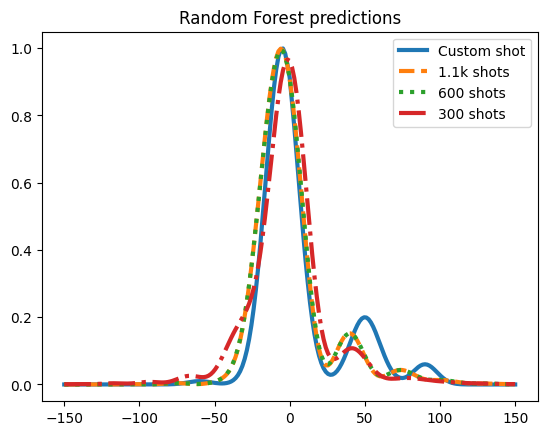

In [48]:
y_cust_shot=func(t_200,1,-5,11,
       0.06,+90,8,
      0.2,+50,10,
      0.01,-60,8,
    0.01,0,0.1)
y_predict_cust_rf=roundmodel_rf.predict([y_cust_shot])
X_predict_cust_rf=roundmodel_rf.X_predict
#plot_example(y_cust_shot,t_200,y_predict_cust_rf[0], X_predict_cust_rf[0])
y_predict_cust_rf_600=roundmodel_rf_600.predict([y_cust_shot])
X_predict_cust_rf_600=roundmodel_rf_600.X_predict
y_predict_cust_rf_300=roundmodel_rf_300.predict([y_cust_shot])
X_predict_cust_rf_300=roundmodel_rf_300.X_predict

plt.plot(t_200,y_cust_shot,label='Custom shot',linewidth=3)
#plt.plot(df_time_val,y_predict_lin_backforw[shot_index],label='Prediction (Linear)')
plt.plot(t_200,y_predict_cust_rf[0],label='1.1k shots',linewidth=3,linestyle='--')
plt.plot(t_200,y_predict_cust_rf_600[0],label='600 shots',linewidth=3,linestyle=':')
plt.plot(t_200,y_predict_cust_rf_300[0],label='300 shots',linewidth=3,linestyle='-.')
plt.title('Random Forest predictions')
plt.legend()


In [49]:
#same for the NN

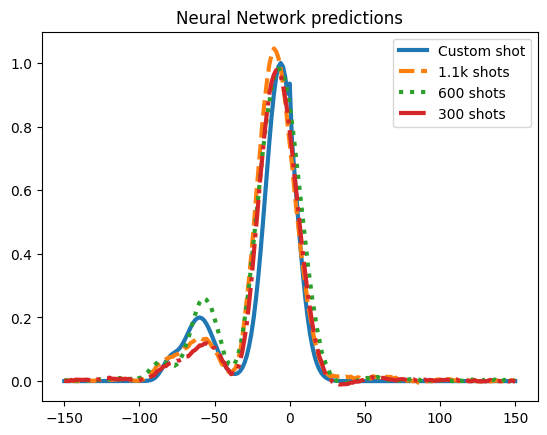

In [50]:
y_cust_shot=func(t_200,1,-6,10,
       0.05,-80,5,
      0.2,-60,10,
      0.,60,8,
    0.1,0,0.1)

y_predict_cust_nn=roundmodelNN.predict(pd.DataFrame([y_cust_shot]))
X_predict_cust_nn=roundmodelNN.X_predict_nn
#plot_example(y_cust_shot,t_200,y_predict_cust_rf[0], X_predict_cust_rf[0])
y_predict_cust_nn_600=roundmodelNN_600.predict(pd.DataFrame([y_cust_shot]))
X_predict_cust_nn_600=roundmodelNN_600.X_predict_nn
y_predict_cust_nn_300=roundmodelNN_300.predict(pd.DataFrame([y_cust_shot]))
X_predict_cust_nn_300=roundmodelNN_300.X_predict_nn

plt.plot(t_200,y_cust_shot,label='Custom shot',linewidth=3)
#plt.plot(df_time_val,y_predict_lin_backforw[shot_index],label='Prediction (Linear)')
plt.plot(t_200,y_predict_cust_nn[0],label='1.1k shots',linewidth=3,linestyle='--')
plt.plot(t_200,y_predict_cust_nn_600[0],label='600 shots',linewidth=3,linestyle=':')
plt.plot(t_200,y_predict_cust_nn_300[0],label='300 shots',linewidth=3,linestyle='-.')
plt.title('Neural Network predictions')
plt.legend()

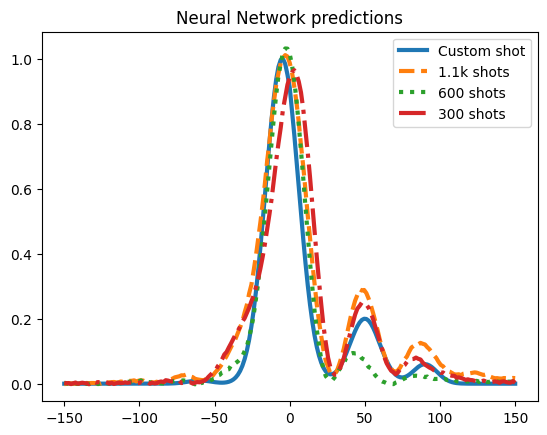

In [51]:
y_cust_shot=func(t_200,1,-5,11,
       0.06,+90,8,
      0.2,+50,10,
      0.01,-60,8,
    0.01,0,0.1)
y_predict_cust_nn=roundmodelNN.predict(pd.DataFrame([y_cust_shot]))
X_predict_cust_nn=roundmodelNN.X_predict_nn
#plot_example(y_cust_shot,t_200,y_predict_cust_rf[0], X_predict_cust_rf[0])
y_predict_cust_nn_600=roundmodelNN_600.predict(pd.DataFrame([y_cust_shot]))
X_predict_cust_nn_600=roundmodelNN_600.X_predict_nn
y_predict_cust_nn_300=roundmodelNN_300.predict(pd.DataFrame([y_cust_shot]))
X_predict_cust_nn_300=roundmodelNN_300.X_predict_nn

plt.plot(t_200,y_cust_shot,label='Custom shot',linewidth=3)
#plt.plot(df_time_val,y_predict_lin_backforw[shot_index],label='Prediction (Linear)')
plt.plot(t_200,y_predict_cust_nn[0],label='1.1k shots',linewidth=3,linestyle='--')
plt.plot(t_200,y_predict_cust_nn_600[0],label='600 shots',linewidth=3,linestyle=':')
plt.plot(t_200,y_predict_cust_nn_300[0],label='300 shots',linewidth=3,linestyle='-.')
plt.title('Neural Network predictions')
plt.legend()

# PCA analysis

### Train the PCA (on the AVG data)

In [52]:
pca_comp=15
#normalize the pulse dataset
scaler=StandardScaler()
y_train_norm = scaler.fit_transform(y_train) #only on the training set
#Train the pca space using the _morm
pca_space=PCA(n_components=pca_comp).fit(y_train_norm)
#convert to pca space
y_train_pca=pca_space.transform(y_train_norm)
#also renorm and transform the test set
y_test_norm=scaler.transform(y_test) #using teh same norm as the TRAIN set)
y_test_pca=pca_space.transform(y_test_norm)

Text(0, 0.5, 'cumulative explained variance')

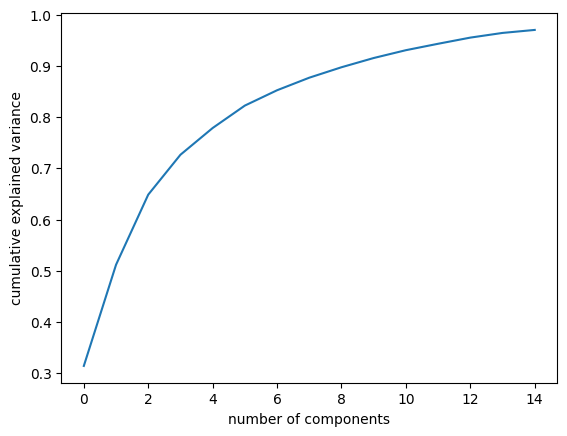

In [53]:
plt.plot(np.cumsum(pca_space.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

Text(0.5, 0, 'Eigenvector')

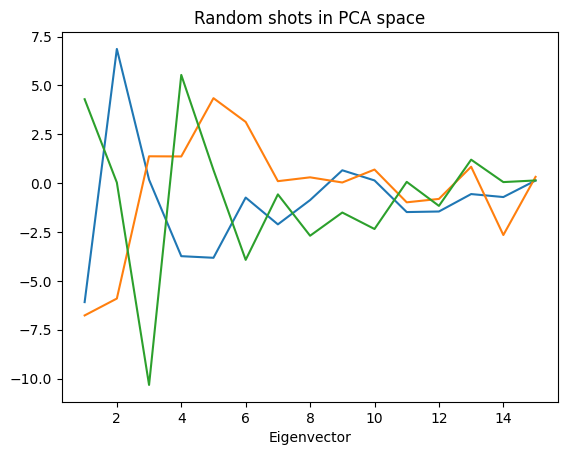

In [54]:
x_aux=np.linspace(1,pca_comp,pca_comp)
plt.plot(x_aux,y_train_pca[50])
plt.plot(x_aux,y_train_pca[20])
plt.plot(x_aux,y_train_pca[10])
plt.title('Random shots in PCA space')
plt.xlabel('Eigenvector')

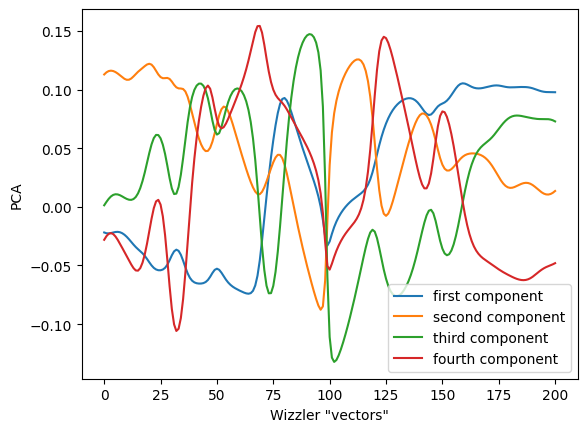

In [55]:
plt.plot(pca_space.components_[0],label='first component')
plt.plot(pca_space.components_[1],label='second component')
plt.plot(pca_space.components_[2],label='third component')
plt.plot(pca_space.components_[3],label='fourth component')
plt.xlabel('Wizzler "vectors"')
plt.ylabel('PCA')
plt.legend()

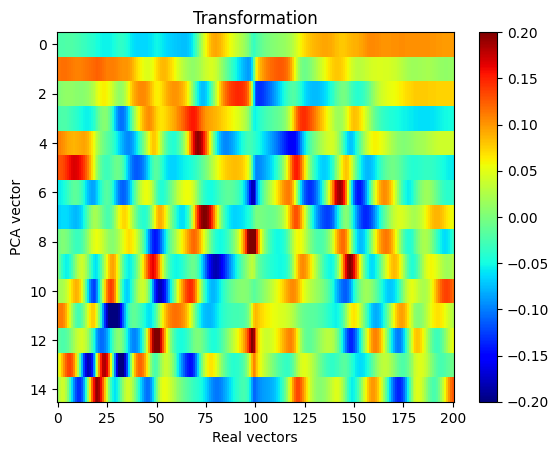

In [56]:
fig, ax = plt.subplots()
c=plt.imshow(pca_space.components_,interpolation='none',vmin=-0.2,vmax=0.2,cmap='jet')
ax.set_title('Transformation')
ax.set_xlabel('Real vectors')
ax.set_ylabel('PCA vector')
plt.gca().set_aspect('auto')
cbar =fig.colorbar(c, ax=ax)

### Train a Random Forest roundtrip with PCA

In [57]:
%%time
roundmodel_rf_pca=rf.ROUNDmodelRF(X_train,X_test,y_train_pca,y_test_pca)
roundmodel_rf_pca.train()
y_predict_round_pca=roundmodel_rf_pca.predict(y_test_pca)
#To calculate the error, y_predict needs to be renorm back to real space
y_predict_inv_pca=pca_space.inverse_transform(y_predict_round_pca)
y_predict_rf_pca=scaler.inverse_transform(y_predict_inv_pca)

CPU times: user 2.73 s, sys: 105 ms, total: 2.84 s
Wall time: 2.53 s


/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [58]:
#Error calculation
mae_error_rf_pca=abs(y_test-y_predict_rf_pca)
mae_error_rf_pca=mae_error_rf_pca.sum(axis=1)/y_test.shape[1] #sum error / num columns

### Train NN roundtrip with PCA

In [59]:
roundmodelNN_pca=fcnn.ROUNDmodelNN(X_train,pd.DataFrame(y_train_pca),X_test,pd.DataFrame(y_test_pca),device)
roundmodelNN_pca.train(400,#epochs FWD
                 20,#batch size FWD
                 40, #print freq FWD
                 0.001, #learning rate FWF
                   600,#epochs  BWD
                 20,#batch size BWD
                 50, #print freq BWD
                 0.001) #learning rate BWD
y_predict_nn_round_pca=roundmodelNN_pca.predict(pd.DataFrame(y_test_pca))
#To calculate the error, y_predict needs to be renorm back to real space
y_predict_inv_pca=pca_space.inverse_transform(y_predict_nn_round_pca)
y_predict_nn_pca=scaler.inverse_transform(y_predict_inv_pca)

Training the forward model
Finished epoch 0,latest loss 13.14393138885498
Finished epoch 40,latest loss 5.225641250610352
Finished epoch 80,latest loss 4.326493740081787
Finished epoch 120,latest loss 3.9192585945129395
Finished epoch 160,latest loss 3.626126289367676
Finished epoch 200,latest loss 3.3714404106140137
Finished epoch 240,latest loss 3.1952481269836426
Finished epoch 280,latest loss 3.071601152420044
Finished epoch 320,latest loss 2.9615323543548584
Finished epoch 360,latest loss 2.8664896488189697
Finished epoch 399,latest loss 2.7843739986419678
Total time taken to train the model: 25.91s
Training the backward model
Finished epoch 0,latest loss 1.025380253791809
Finished epoch 50,latest loss 0.5050091743469238
Finished epoch 100,latest loss 0.45191386342048645
Finished epoch 150,latest loss 0.43524405360221863
Finished epoch 200,latest loss 0.4291624426841736
Finished epoch 250,latest loss 0.40122443437576294
Finished epoch 300,latest loss 0.38448798656463623
Finished e

In [60]:
#Error calculation
mae_error_nn_pca=abs(y_test-y_predict_nn_pca)
mae_error_nn_pca=mae_error_nn_pca.sum(axis=1)/y_test.shape[1] #sum error / num columns

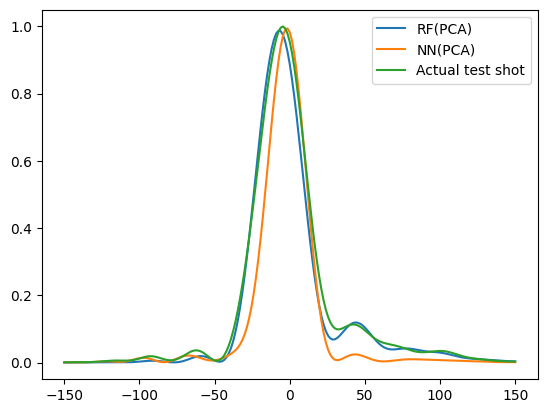

In [61]:
shot_index=8
plt.plot(t_200,y_predict_rf_pca[shot_index],label='RF(PCA)')
plt.plot(t_200,y_predict_nn_pca[shot_index],label='NN(PCA)')
plt.plot(t_200,y_test.iloc[shot_index],label='Actual test shot')
plt.legend()

Text(0.5, 1.0, 'Roundtrip Model Accuracy')

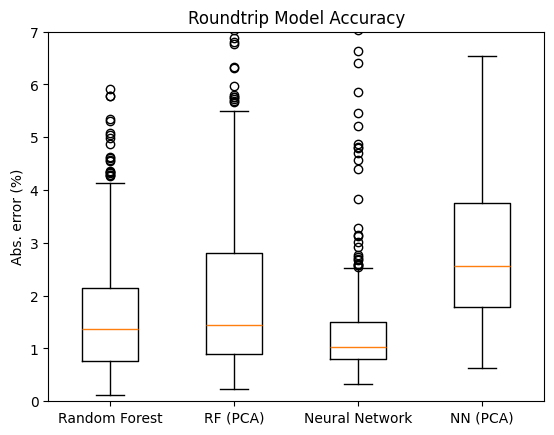

In [62]:
error_dist=[100*mae_error_round,
            100*mae_error_rf_pca,
           100*error_round_model_nn,
           100*mae_error_nn_pca]
labels=['Random Forest','RF (PCA)',
       'Neural Network', 'NN (PCA)']
plt.boxplot(error_dist,labels=labels)
#plt.boxplot(df_error_forward_7k_whole)
#plt.boxplot(df_error_forward_4k_whole)
plt.ylim(0,7)
plt.ylabel('Abs. error (%)')
plt.title('Roundtrip Model Accuracy')

### Custom shots in the PCA

In [63]:
'''
1) Draw a custom shot
2) Convert to PCA space
3) Convert ti back to real space
4) Go trought the roundtrip model (in real space)
'''

'\n1) Draw a custom shot\n2) Convert to PCA space\n3) Convert ti back to real space\n4) Go trought the roundtrip model (in real space)\n'

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


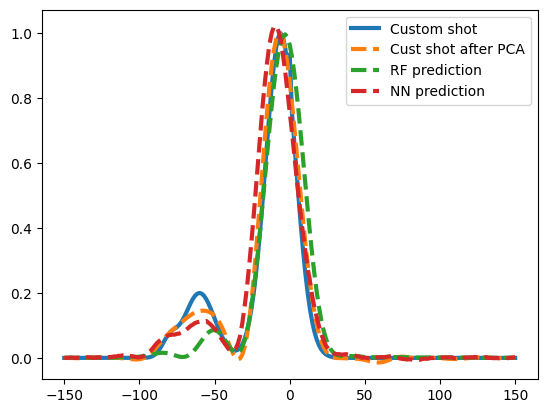

In [64]:
y_cust_shot=func(t_200,1,-6,10,
       0.05,-80,5,
      0.2,-60,10,
      0.,60,8,
    0.1,0,0.1)
#Norm shot
y_cust_shot_norm=scaler.transform([y_cust_shot])
#convert to PCA space
y_cust_shot_pca=pca_space.transform(y_cust_shot_norm)
#back to real space
y_cust_shot_real=pca_space.inverse_transform(y_cust_shot_pca)
#renorm
y_cust_shot_pred_pca=scaler.inverse_transform(y_cust_shot_real)

#Pass the custom shot through the roundtrip model
y_predict_cust_rf=roundmodel_rf.predict(y_cust_shot_pred_pca)
y_predict_cust_nn=roundmodelNN.predict(pd.DataFrame([y_cust_shot_pred_pca[0]]))


plt.plot(t_200,y_cust_shot,label='Custom shot',linewidth=3)
#plt.plot(df_time_val,y_predict_lin_backforw[shot_index],label='Prediction (Linear)')
plt.plot(t_200,y_cust_shot_pred_pca[0],label='Cust shot after PCA',linewidth=3,linestyle='--')
plt.plot(t_200,y_predict_cust_rf[0],label='RF prediction',linewidth=3,linestyle='--')
plt.plot(t_200,y_predict_cust_nn[0],label='NN prediction',linewidth=3,linestyle='--')
#plt.title('Neural Network predictions')
plt.legend()

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


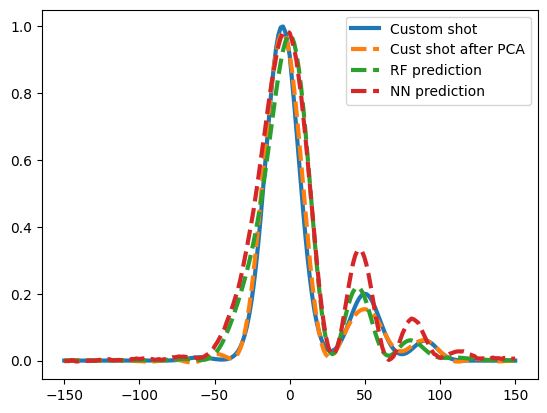

In [71]:
y_cust_shot=func(t_200,1,-5,11,
       0.06,+90,8,
      0.2,+50,10,
      0.01,-60,8,
    0.01,0,0.1)
#Norm shot
y_cust_shot_norm=scaler.transform([y_cust_shot])
#convert to PCA space
y_cust_shot_pca=pca_space.transform(y_cust_shot_norm)
#back to real space
y_cust_shot_real=pca_space.inverse_transform(y_cust_shot_pca)
#renorm
y_cust_shot_pred_pca=scaler.inverse_transform(y_cust_shot_real)

#Pass the custom shot through the roundtrip model
y_predict_cust_rf=roundmodel_rf.predict(y_cust_shot_pred_pca)
y_predict_cust_nn=roundmodelNN.predict(pd.DataFrame([y_cust_shot_pred_pca[0]]))


plt.plot(t_200,y_cust_shot,label='Custom shot',linewidth=3)
#plt.plot(df_time_val,y_predict_lin_backforw[shot_index],label='Prediction (Linear)')
plt.plot(t_200,y_cust_shot_pred_pca[0],label='Cust shot after PCA',linewidth=3,linestyle='--')
plt.plot(t_200,y_predict_cust_rf[0],label='RF prediction',linewidth=3,linestyle='--')
plt.plot(t_200,y_predict_cust_nn[0],label='NN prediction',linewidth=3,linestyle='--')
#plt.title('Neural Network predictions')
plt.legend()

### Is the custom shot inside the PCA parameter space?

In [75]:
y_cust_shot_pca[0][0]

3.435144745248722

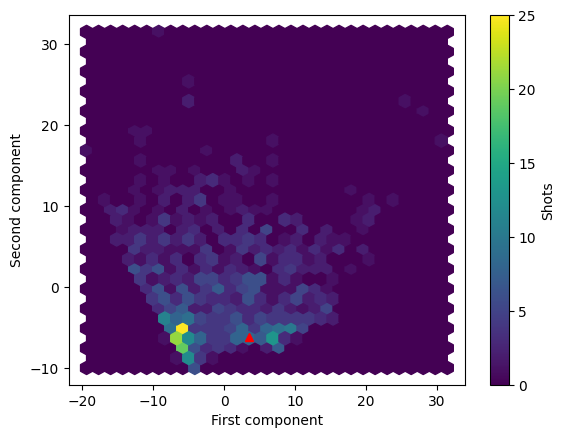

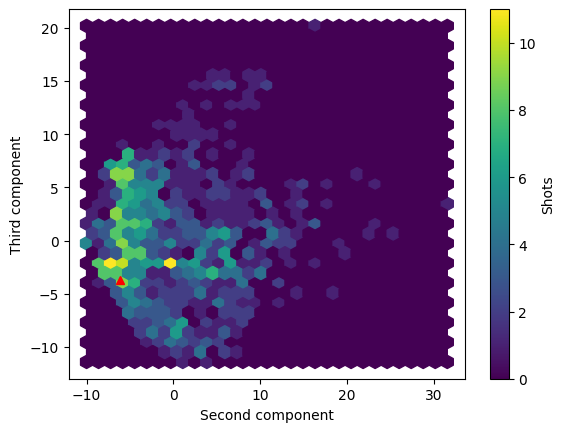

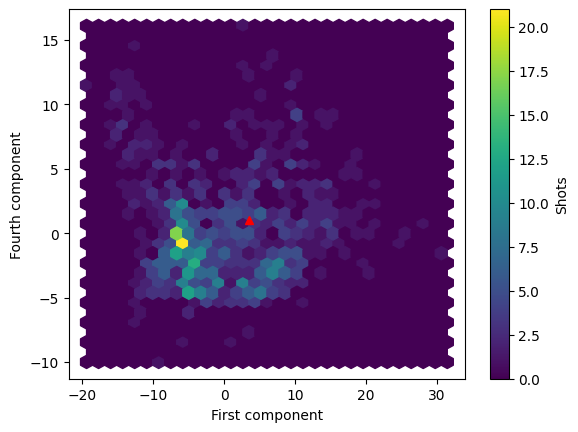

In [76]:
fig, ax = plt.subplots()
h1=ax.hexbin(y_train_pca[:,0], y_train_pca[:,1],gridsize=30)#,cmap='jet')
plt.plot(y_cust_shot_pca[0][0],y_cust_shot_pca[0][1],marker='^',color='red',linestyle='None')#,label='Good performers')
ax.set_xlabel('First component')
ax.set_ylabel('Second component')
#ax.set_xlim(-3,3)
#ax.set_ylim(-3,4)
cbar =fig.colorbar(h1, ax=ax)
cbar.set_label('Shots')
#plt.legend()
plt.show()

fig2, ax2 = plt.subplots()
h2=ax2.hexbin(y_train_pca[:,1], y_train_pca[:,2],gridsize=30)#,cmap='jet')
plt.plot(y_cust_shot_pca[0][1],y_cust_shot_pca[0][2],marker='^',color='red',linestyle='None')
ax2.set_xlabel('Second component')
ax2.set_ylabel('Third component')
#ax.set_xlim(-3,3)
#ax.set_ylim(-3,4)
cbar2 =fig.colorbar(h2, ax=ax2)
cbar2.set_label('Shots')
#plt.legend()
plt.show()

fig3, ax3 = plt.subplots()
h3=ax3.hexbin(y_train_pca[:,0], y_train_pca[:,3],gridsize=30)#,cmap='jet')
plt.plot(y_cust_shot_pca[0][0],y_cust_shot_pca[0][3],marker='^',color='red',linestyle='None')
ax3.set_xlabel('First component')
ax3.set_ylabel('Fourth component')
#ax.set_xlim(-3,3)
#ax.set_ylim(-3,4)
cbar3 =fig.colorbar(h3, ax=ax3)
cbar3.set_label('Shots')
#plt.legend()
plt.show()

### Cust shot through the PCA roundtrip models

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


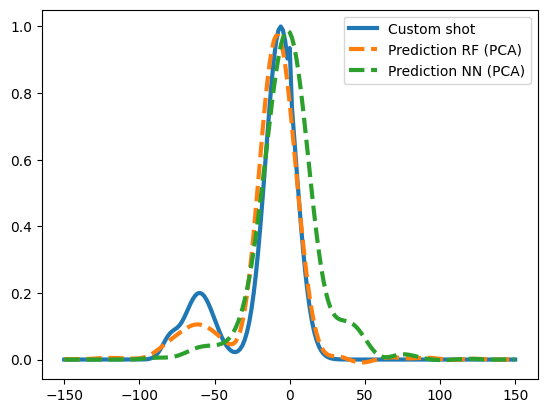

In [66]:
y_cust_shot=func(t_200,1,-6,10,
       0.05,-80,5,
      0.2,-60,10,
      0.,60,8,
    0.1,0,0.1)
#Norm shot
y_cust_shot_norm=scaler.transform([y_cust_shot])
#convert to PCA space
y_cust_shot_pca=pca_space.transform(y_cust_shot_norm)

#pass it through the roundtrip model
y_predict_round_rf_pca=roundmodel_rf_pca.predict(y_cust_shot_pca)
#back to real space
y_cust_shot_real_rf=pca_space.inverse_transform(y_predict_round_rf_pca)
#renorm
y_cust_shot_pred_pca=scaler.inverse_transform(y_cust_shot_real_rf)

#pass it through the roundtrip model NN
y_predict_round_nn_pca=roundmodelNN_pca.predict(pd.DataFrame([y_cust_shot_pca[0]]))
#back to real space
y_cust_shot_real_nn=pca_space.inverse_transform(y_predict_round_nn_pca)
#renorm
y_cust_shot_pred_nn_pca=scaler.inverse_transform(y_cust_shot_real_nn)

plt.plot(t_200,y_cust_shot,label='Custom shot',linewidth=3)
#plt.plot(df_time_val,y_predict_lin_backforw[shot_index],label='Prediction (Linear)')
plt.plot(t_200,y_cust_shot_pred_pca[0],label='Prediction RF (PCA)',linewidth=3,linestyle='--')
plt.plot(t_200,y_cust_shot_pred_nn_pca[0],label='Prediction NN (PCA)',linewidth=3,linestyle='--')
#plt.title('Neural Network predictions')
plt.legend()

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


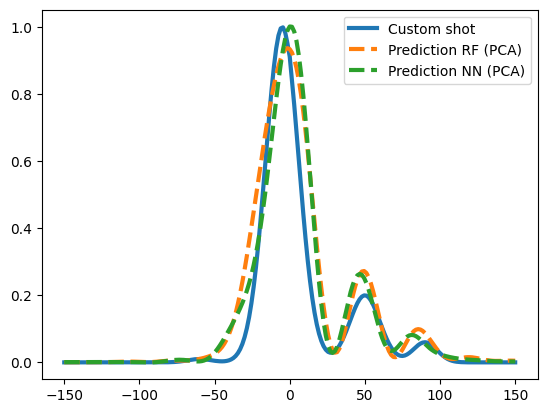

In [67]:
y_cust_shot=func(t_200,1,-5,11,
       0.06,+90,8,
      0.2,+50,10,
      0.01,-60,8,
    0.01,0,0.1)
#Norm shot
y_cust_shot_norm=scaler.transform([y_cust_shot])
#convert to PCA space
y_cust_shot_pca=pca_space.transform(y_cust_shot_norm)

#pass it through the roundtrip model RF
y_predict_round_rf_pca=roundmodel_rf_pca.predict(y_cust_shot_pca)
#back to real space
y_cust_shot_real_rf=pca_space.inverse_transform(y_predict_round_rf_pca)
#renorm
y_cust_shot_pred_rf_pca=scaler.inverse_transform(y_cust_shot_real_rf)

#pass it through the roundtrip model NN
y_predict_round_nn_pca=roundmodelNN_pca.predict(pd.DataFrame([y_cust_shot_pca[0]]))
#back to real space
y_cust_shot_real_nn=pca_space.inverse_transform(y_predict_round_nn_pca)
#renorm
y_cust_shot_pred_nn_pca=scaler.inverse_transform(y_cust_shot_real_nn)

plt.plot(t_200,y_cust_shot,label='Custom shot',linewidth=3)
#plt.plot(df_time_val,y_predict_lin_backforw[shot_index],label='Prediction (Linear)')
plt.plot(t_200,y_cust_shot_pred_rf_pca[0],label='Prediction RF (PCA)',linewidth=3,linestyle='--')
plt.plot(t_200,y_cust_shot_pred_nn_pca[0],label='Prediction NN (PCA)',linewidth=3,linestyle='--')
#plt.title('Neural Network predictions')
plt.legend()

In [68]:
print(len(y_train.columns))

201


In [69]:
a=np.array([1,2,3,4])
b=np.array([5,6,7,8])
p=[x+y for x,y in zip(a,b)]

In [70]:
p

[6, 8, 10, 12]